# Create mean images for cellpose


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from pprint import pprint
import os
from cellpose import models
from cellpose import io as cpio
from cellpose import plot
import tifffile
from skimage import exposure
import glob

In [2]:
# From one example
ops_fn = r'F:\036\plane_6\015\plane0\ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()
np.sort(list(ops.keys()))

array(['1Preg', 'Lx', 'Lxc', 'Ly', 'Lyc', 'NRsm', 'Vcorr', 'Vmap', 'Vmax',
       'Vsplit', 'align_by_chan', 'allow_overlap', 'anatomical_only',
       'aspect', 'badframes', 'baseline', 'batch_size', 'bidi_corrected',
       'bidiphase', 'block_size', 'bruker', 'bruker_bidirectional',
       'cellprob_threshold', 'chan2_thres', 'classifier_path', 'combined',
       'connected', 'corrXY', 'corrXY1', 'data_path', 'date_proc',
       'delete_bin', 'denoise', 'diameter', 'do_bidiphase',
       'do_registration', 'fast_disk', 'filelist', 'flow_threshold',
       'force_refImg', 'force_sktiff', 'frames_include', 'fs',
       'functional_chan', 'h5list', 'h5py', 'h5py_key', 'high_pass',
       'ignore_flyback', 'ihop', 'inner_neuropil_radius', 'input_format',
       'keep_movie_raw', 'lam_percentile', 'look_one_level_down',
       'max_iterations', 'max_overlap', 'max_proj', 'maxregshift',
       'maxregshiftNR', 'meanImg', 'meanImgE', 'mesoscan',
       'min_neuropil_pixels', 'move_bin', 'm

In [3]:
mimg = ops['meanImg']
mimg.shape

(387, 687)

In [5]:
# save mimg as tiff
mimg_fn = r'F:\036\plane_6\015\plane0\mimg.tif'
import tifffile
tifffile.imwrite(mimg_fn, mimg)


In [12]:
# save mimg as png
mimg_fn = r'F:\036\plane_4\901\plane0\mimg.png'
plt.imsave(mimg_fn, mimg, cmap='gray')

In [14]:
# Works reasonably well with CP model.
# Missing ~5 neurons out of ~215 (2.3%)
# Load the results
seg_fn = r'F:\036\plane_4\901\plane0\mimg_seg.npy'
seg = np.load(seg_fn, allow_pickle=True).item()
seg.keys()

dict_keys(['outlines', 'colors', 'masks', 'chan_choose', 'img', 'filename', 'flows', 'ismanual', 'manual_changes', 'model_path', 'flow_threshold', 'cellprob_threshold'])

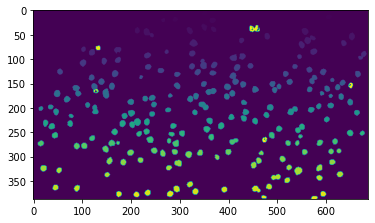

In [18]:
%matplotlib inline
plt.imshow(seg['masks'])

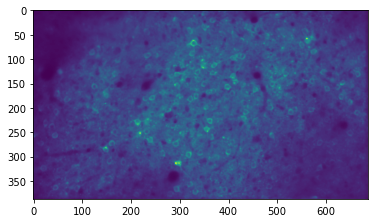

In [20]:
plt.imshow(seg['img'])

In [22]:
# Look at other examples
ops_fn = r'F:\036\plane_1\901\plane0\ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()
mimg = ops['meanImg']
mimg_fn = r'F:\036\plane_1\901\plane0\mimg.png'
plt.imsave(mimg_fn, mimg, cmap='gray')


In [23]:
# Look at other examples
ops_fn = r'F:\036\plane_8\901\plane0\ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()
mimg = ops['meanImg']
mimg_fn = r'F:\036\plane_8\901\plane0\mimg.png'
plt.imsave(mimg_fn, mimg, cmap='gray')

In [24]:
# Look at other examples
ops_fn = r'F:\036\plane_7\901\plane0\ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()
mimg = ops['meanImg']
mimg_fn = r'F:\036\plane_7\901\plane0\mimg.png'
plt.imsave(mimg_fn, mimg, cmap='gray')

# Running cellpose in script

In [4]:
h5_dir_1 = Path('J:/')
h5_dir_2 = Path('F:/')
mice =          [25,    27,   30,   36,     37,     38,     39,     41,     52,     53,     54,     56]
expert_mice = [25, 27, 30, 36, 39, 52]
ref_sessions = [4,3,3,1,1,3]
exp_sessions = [19,10,21,17,23,21]



In [16]:
emi = 3
plane = 1

mouse = expert_mice[emi]
if emi < 3:
    h5_dir = h5_dir_1
else:
    h5_dir = h5_dir_2

plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
# sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
# session_nums = sts_reg['selected_session_num']
# For now, just use all sessions
# Change this to the above lines after finishing session_to_session_registration
# Either using 220605_roi_collection_and_QC.py 
# or running session-to-session registration using another method (CNN-based, or using ROI masks)

session_nums = os.listdir(plane_dir) if os.path.isdir(plane_dir) else []
session_nums = [sn for sn in session_nums if os.path.isdir(plane_dir / sn)]


In [20]:
model = models.CellposeModel(gpu=True, model_type='cyto')
channels = [0,0]

In [32]:
si = 0
session_num = session_nums[si]
ops = np.load(plane_dir / session_num / 'plane0' / 'ops.npy', allow_pickle=True).item()
mimg = ops['meanImg']
# save to tif
mimg_fn = h5_dir / 'mimg' / f'JK{mouse}_plane_{plane}_{session_num}_mimg.tif'
tifffile.imwrite(mimg_fn, mimg)

mimg_eq = exposure.equalize_adapthist(mimg/np.max(mimg), clip_limit=0.03)
mimg_clahe_fn = h5_dir / 'mimg' / f'JK{mouse}_plane_{plane}_{session_num}_mimg_clahe.tif'
tifffile.imwrite(mimg_clahe_fn, mimg_eq)


In [36]:
diameter = 10
fn = mimg_clahe_fn
img = cpio.imread(fn)
masks, flows, styles = model.eval(img, diameter=diameter, channels=channels)
cpio.masks_flows_to_seg(mimg, masks, flows, diameter, fn, channels=channels)

In [12]:
import cv2
from cellpose import transforms, utils
def masks_flows_to_seg_modified(images, masks, flows, diams, model_types, file_names, save_fns, channels=None):
    """ save output of model eval to be loaded in GUI
    Modified to have a specific save_fn, to compare across different models and diameters

    can be list output (run on multiple images) or single output (run on single image)

    saved to file_names[k]+'_seg.npy'
    
    Parameters
    -------------

    images: (list of) 2D or 3D arrays
        images input into cellpose

    masks: (list of) 2D arrays, int
        masks output from Cellpose.eval, where 0=NO masks; 1,2,...=mask labels

    flows: (list of) list of ND arrays 
        flows output from Cellpose.eval

    diams: float array
        diameters used to run Cellpose
    
    model_types: (list of) str
        type of model used to run Cellpose, e.g. 'cyto' or 'CP'

    file_names: (list of) str
        names of files of images

    save_fns: (list of) str
        names of files to save the results

    channels: list of int (optional, default None)
        channels used to run Cellpose    
    
    """
    
    if channels is None:
        channels = [0,0]
    
    if isinstance(masks, list):
        if not isinstance(diams, (list, np.ndarray)):
            diams = diams * np.ones(len(masks), np.float32)
        for k, [image, mask, flow, diam, model_type, file_name, save_fn] in \
            enumerate(zip(images, masks, flows, diams, model_types, file_names, save_fns)):
            channels_img = channels
            if channels_img is not None and len(channels) > 2:
                channels_img = channels[k]
            masks_flows_to_seg_modified(image, mask, flow, diam, model_type, file_name, save_fn, channels_img)
        return

    if len(channels)==1:
        channels = channels[0]
    
    flowi = []
    if flows[0].ndim==3:
        Ly, Lx = masks.shape[-2:]
        flowi.append(cv2.resize(flows[0], (Lx, Ly), interpolation=cv2.INTER_NEAREST)[np.newaxis,...])
    else:
        flowi.append(flows[0])
    
    if flows[0].ndim==3:
        cellprob = (np.clip(transforms.normalize99(flows[2]),0,1) * 255).astype(np.uint8)
        cellprob = cv2.resize(cellprob, (Lx, Ly), interpolation=cv2.INTER_NEAREST)
        flowi.append(cellprob[np.newaxis,...])
        flowi.append(np.zeros(flows[0].shape, dtype=np.uint8))
        flowi[-1] = flowi[-1][np.newaxis,...]
    else:
        flowi.append((np.clip(transforms.normalize99(flows[2]),0,1) * 255).astype(np.uint8))
        flowi.append((flows[1][0]/10 * 127 + 127).astype(np.uint8))
    if len(flows)>2:
        flowi.append(flows[3])
        flowi.append(np.concatenate((flows[1], flows[2][np.newaxis,...]), axis=0))
    outlines = masks * utils.masks_to_outlines(masks)
    if masks.ndim==3:
        np.save(save_fns,
                    {'outlines': outlines.astype(np.uint16) if outlines.max()<2**16-1 else outlines.astype(np.uint32),
                     'masks': masks.astype(np.uint16) if outlines.max()<2**16-1 else masks.astype(np.uint32),
                     'chan_choose': channels,
                     'img': images,
                     'ismanual': np.zeros(masks.max(), bool),
                     'filename': file_names,
                     'flows': flowi,
                     'est_diam': diams,
                     'model_type': model_types})
    else:
        if images.shape[0]<8:
            np.transpose(images, (1,2,0))
        np.save(save_fns,
                    {'img': images,
                     'outlines': outlines.astype(np.uint16) if outlines.max()<2**16-1 else outlines.astype(np.uint32),
                     'masks': masks.astype(np.uint16) if masks.max()<2**16-1 else masks.astype(np.uint32),
                     'chan_choose': channels,
                     'ismanual': np.zeros(masks.max(), bool),
                     'filename': file_names,
                     'flows': flowi,
                     'est_diam': diams,
                     'model_type': model_types})
        
def run_and_save_cellpose(fn, diameter=10, model_type='cyto', channels=[0,0]):
    img = cpio.imread(fn)
    model = models.CellposeModel(gpu=True, model_type=model_type)
    masks, flows, styles = model.eval(img, diameter=diameter, channels=channels)
    save_dir = fn.parent / 'cellpose'
    if not save_dir.exists():
        os.makedirs(save_dir, exist_ok=True)
    save_fn = str(save_dir / (fn.stem + f'_{model_type}_{diameter}_seg.npy'))        
    if isinstance(fn, Path):
        fn = str(fn)
    masks_flows_to_seg_modified(mimg, masks, flows, diameter, model_type, fn, save_fn, channels=channels)

In [48]:
channels = [0,0]
model_type_list = ['cyto', 'CP']
diameter_list = range(8,17,2)
for si in range(len(session_nums)):
    session_num = session_nums[si]
    ops = np.load(plane_dir / session_num / 'plane0' / 'ops.npy', allow_pickle=True).item()
    mimg = ops['meanImg']
    # save to tif
    mimg_fn = h5_dir / 'mimg' / f'JK{mouse:03d}_plane_{plane}_{session_num}_mimg.tif'
    tifffile.imwrite(mimg_fn, mimg)

    mimg_eq = exposure.equalize_adapthist(mimg/np.max(mimg), clip_limit=0.03)
    mimg_clahe_fn = h5_dir / 'mimg' / f'JK{mouse:03d}_plane_{plane}_{session_num}_mimg_clahe.tif'
    tifffile.imwrite(mimg_clahe_fn, mimg_eq)

    for model_type in model_type_list:
        for diameter in diameter_list:
            run_and_save_cellpose(mimg_clahe_fn, model, diameter=diameter, model_type=model_type, channels=channels)
            run_and_save_cellpose(mimg_fn, model, diameter=diameter, model_type=model_type, channels=channels)

    


In [49]:
emi = 3

mouse = expert_mice[emi]
if emi < 3:
    h5_dir = h5_dir_1
else:
    h5_dir = h5_dir_2

for plane in range(2,9):
    plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
    # sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
    # session_nums = sts_reg['selected_session_num']
    # For now, just use all sessions
    # Change this to the above lines after finishing session_to_session_registration
    # Either using 220605_roi_collection_and_QC.py 
    # or running session-to-session registration using another method (CNN-based, or using ROI masks)

    session_nums = os.listdir(plane_dir) if os.path.isdir(plane_dir) else []
    session_nums = [sn for sn in session_nums if os.path.isdir(plane_dir / sn)]

    for si in range(len(session_nums)):
        session_num = session_nums[si]
        ops = np.load(plane_dir / session_num / 'plane0' / 'ops.npy', allow_pickle=True).item()
        mimg = ops['meanImg']
        # save to tif
        mimg_fn = h5_dir / 'mimg' / f'JK{mouse:03d}_plane_{plane}_{session_num}_mimg.tif'
        tifffile.imwrite(mimg_fn, mimg)

        mimg_eq = exposure.equalize_adapthist(mimg/np.max(mimg), clip_limit=0.03)
        mimg_clahe_fn = h5_dir / 'mimg' / f'JK{mouse:03d}_plane_{plane}_{session_num}_mimg_clahe.tif'
        tifffile.imwrite(mimg_clahe_fn, mimg_eq)

        for model_type in model_type_list:
            for diameter in diameter_list:
                run_and_save_cellpose(mimg_clahe_fn, diameter=diameter, model_type=model_type, channels=channels)
                run_and_save_cellpose(mimg_fn, diameter=diameter, model_type=model_type, channels=channels)

OSError: [Errno 22] Invalid argument

In [50]:
plane

7

In [51]:
session_num

'9998_2'

In [52]:
model_type

'CP'

# First batch of systemic search
- JK036 planes 1-7
- plane 7 session 9998_2 'CP' model with diameter 16 failed
- Gather # of ROIs

In [ ]:
base_dir = Path(r'F:\mimg\cellpose')
model_type_list = ['cyto', 'CP']
diameter_list = range(8,17,2)

mouse=36
plane=1
lane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
# sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
# session_nums = sts_reg['selected_session_num']
# For now, just use all sessions
# Change this to the above lines after finishing session_to_session_registration
# Either using 220605_roi_collection_and_QC.py 
# or running session-to-session registration using another method (CNN-based, or using ROI masks)

session_nums = os.listdir(plane_dir) if os.path.isdir(plane_dir) else []
session_nums = [sn for sn in session_nums if os.path.isdir(plane_dir / sn)]

for si in range(len(session_nums)):
    for model_type in model_type_list:
        for diameter in diameter_list:
            save_fn = base_dir / f'JK{mouse}_plane_{plane}_{session_num}_mimg_clahe_{model_type}_{diameter}_seg.npy'
            if os.path.isfile(save_fn):
                seg = np.load(save_fn, allow_pickle=True).item()
                n_roi = len(seg['roi'])
                

In [55]:
seg_fn = r'F:\mimg\cellpose\JK36_plane_7_015_mimg_CP_12_seg.npy'
seg = np.load(seg_fn, allow_pickle=True).item()
seg.keys()

OSError: [Errno 22] Invalid argument

## Error with HDD, trying with JK025-030
- With a little bit of larger diameters (because of higher resolution)

In [17]:
model_type_list = ['cyto', 'CP']
# diameter_list = range(10,25,2)

channels= [0,0]
for emi in [4,5]:
    mouse = expert_mice[emi]
    if emi < 3:
        h5_dir = h5_dir_1
        diameter_list = range(10,25,2)
    else:
        h5_dir = h5_dir_2
        diameter_list = range(8,17,2)


    save_dir_base = Path(r'D:\JK')

    for plane in range(1,9):
        plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
        # sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
        # session_nums = sts_reg['selected_session_num']

        # For now, just use all sessions (to include spontaneous sessions and piezo sessions)
        # Change this to the above lines after finishing session_to_session_registration
        # Either using 220605_roi_collection_and_QC.py 
        # or running session-to-session registration using another method (CNN-based, or using ROI masks)

        session_nums = os.listdir(plane_dir) if os.path.isdir(plane_dir) else []
        session_nums = [sn for sn in session_nums if os.path.isdir(plane_dir / sn)]
        session_nums = [sn for sn in session_nums if sn[0].isdigit()]

        for si in range(len(session_nums)):
            session_num = session_nums[si]
            ops = np.load(plane_dir / session_num / 'plane0' / 'ops.npy', allow_pickle=True).item()
            mimg = ops['meanImg']
            # save to tif        
            mimg_fn = save_dir_base / 'mimg' / f'JK{mouse:03d}_plane_{plane}_{session_num}_mimg.tif'
            if not os.path.isdir(mimg_fn.parent):
                os.makedirs(mimg_fn.parent, exist_ok=True)
            tifffile.imwrite(mimg_fn, mimg)

            mimg_eq = exposure.equalize_adapthist(mimg/np.max(mimg), clip_limit=0.03)
            mimg_clahe_fn = save_dir_base / 'mimg' / f'JK{mouse:03d}_plane_{plane}_{session_num}_mimg_clahe.tif'
            tifffile.imwrite(mimg_clahe_fn, mimg_eq)

            for model_type in model_type_list:
                for diameter in diameter_list:
                    run_and_save_cellpose(mimg_clahe_fn, diameter=diameter, model_type=model_type, channels=channels)
                    run_and_save_cellpose(mimg_fn, diameter=diameter, model_type=model_type, channels=channels)

KeyboardInterrupt: 

# Compare parameters
- Look at the pattern, in each plane
- Figure out if CLAHE is absolutely necessary
    - If not, without CLAHE is better for manual curation
- Investigate which parameter works best 
    - In general, and see if a single parameter can be used across mice and planes

In [65]:
mimg_dir = Path(r'D:\JK\mimg')
cellpose_dir = Path(r'D:\JK\mimg\cellpose')
mouse = 36
plane = 1

session_nums_fns = glob.glob(str(mimg_dir / f'JK{mouse:03d}_plane_{plane}_*_mimg*.tif'))
session_nums = np.unique([fn.split(f'plane_{plane}_')[1].split('_mimg')[0] for fn in session_nums_fns])

model_type_list = ['cyto', 'CP']
# diameter_list = range(10,25,2)

if mouse > 35:
    diameter_list = range(8,17,2)
else:
    diameter_list = range(10,25,2)



In [90]:
def get_seg_num_df(mouse, plane, session_nums, diameter_list):
    seg_num_df = pd.DataFrame(columns=['mouse', 'plane', 'session_num', 'model_type', 'diameter', 'clahe', 'n_roi'])
    for si in range(len(session_nums)):
        session_num = session_nums[si]

        cyto_seg_fns = [cellpose_dir / f'JK{mouse:03d}_plane_{plane}_{session_num}_mimg_cyto_{diameter}_seg.npy' for diameter in diameter_list]
        CP_seg_fns = [cellpose_dir / f'JK{mouse:03d}_plane_{plane}_{session_num}_mimg_CP_{diameter}_seg.npy' for diameter in diameter_list]
        cyto_clahe_seg_fns = [cellpose_dir / f'JK{mouse:03d}_plane_{plane}_{session_num}_mimg_clahe_cyto_{diameter}_seg.npy' for diameter in diameter_list]
        CP_clahe_seg_fns = [cellpose_dir / f'JK{mouse:03d}_plane_{plane}_{session_num}_mimg_clahe_CP_{diameter}_seg.npy' for diameter in diameter_list]

        num_seg_cyto = []
        for seg_fn in cyto_seg_fns:
            if os.path.isfile(seg_fn):
                seg = np.load(seg_fn, allow_pickle=True).item()
                num_seg = np.max(seg['masks'])
                num_seg_cyto.append(num_seg)
        temp_df = pd.DataFrame({'mouse':mouse,
                                'plane':plane,
                                'session_num':session_num,
                                'model_type':'cyto',
                                'diameter':diameter_list,
                                'n_roi':num_seg_cyto,
                                'clahe':False})
        temp_df['clahe'] = temp_df['clahe'].astype(bool)
        seg_num_df = pd.concat([seg_num_df, temp_df], ignore_index=True)

        num_seg_CP = []
        for seg_fn in CP_seg_fns:
            if os.path.isfile(seg_fn):
                seg = np.load(seg_fn, allow_pickle=True).item()
                num_seg = np.max(seg['masks'])
                num_seg_CP.append(num_seg)
        temp_df = pd.DataFrame({'mouse':mouse,
                                'plane':plane,
                                'session_num':session_num,
                                'model_type':'CP',
                                'diameter':diameter_list,
                                'n_roi':num_seg_CP,
                                'clahe':False})
        temp_df['clahe'] = temp_df['clahe'].astype(bool)
        seg_num_df = pd.concat([seg_num_df, temp_df], ignore_index=True)

        num_seg_cyto_clahe = []
        for seg_fn in cyto_clahe_seg_fns:
            if os.path.isfile(seg_fn):
                seg = np.load(seg_fn, allow_pickle=True).item()
                num_seg = np.max(seg['masks'])
                num_seg_cyto_clahe.append(num_seg)
        temp_df = pd.DataFrame({'mouse':mouse,
                                'plane':plane,
                                'session_num':session_num,
                                'model_type':'cyto',
                                'diameter':diameter_list,
                                'n_roi':num_seg_cyto_clahe,
                                'clahe':True})
        temp_df['clahe'] = temp_df['clahe'].astype(bool)
        seg_num_df = pd.concat([seg_num_df, temp_df], ignore_index=True)

        num_seg_CP_clahe = []
        for seg_fn in CP_clahe_seg_fns:
            if os.path.isfile(seg_fn):
                seg = np.load(seg_fn, allow_pickle=True).item()
                num_seg = np.max(seg['masks'])
                num_seg_CP_clahe.append(num_seg)
        temp_df = pd.DataFrame({'mouse':mouse,
                                'plane':plane,
                                'session_num':session_num,
                                'model_type':'CP',
                                'diameter':diameter_list,
                                'n_roi':num_seg_CP_clahe,
                                'clahe':True})
        temp_df['clahe'] = temp_df['clahe'].astype(bool)
        seg_num_df = pd.concat([seg_num_df, temp_df], ignore_index=True)
    return seg_num_df
    


C:\Users\shires\AppData\Local\Temp\ipykernel_24064\825173051.py:41: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  seg_num_df = pd.concat([seg_num_df, temp_df], ignore_index=True)
C:\Users\shires\AppData\Local\Temp\ipykernel_24064\825173051.py:57: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  seg_num_df = pd.concat([seg_num_df, temp_df], ignore_index=True)
C:\Users\shires\AppData\Local\Temp\ipykernel_24064\825173051.py:73: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  seg_num_df = pd.concat([seg_num_df, temp_df], ignore_index=True)
C:\Users\shires\AppData\Local\Temp\ipykernel_24064\825173051.py:25: FutureWa

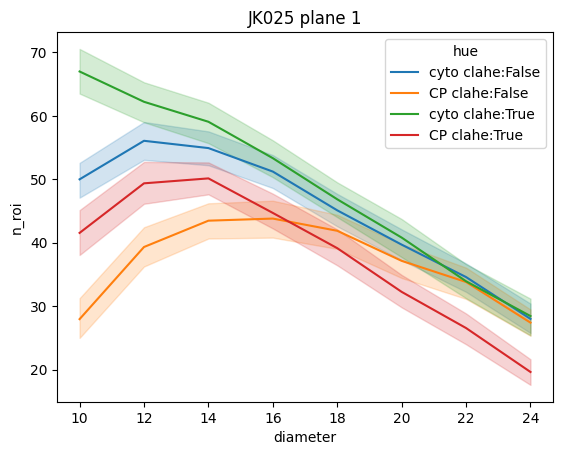

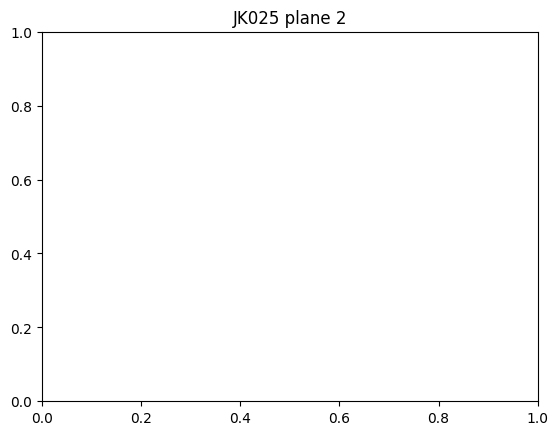

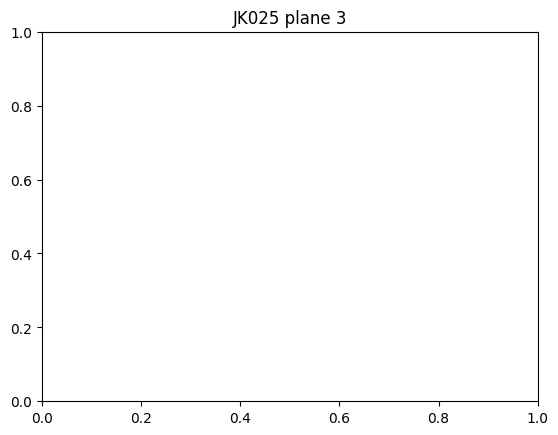

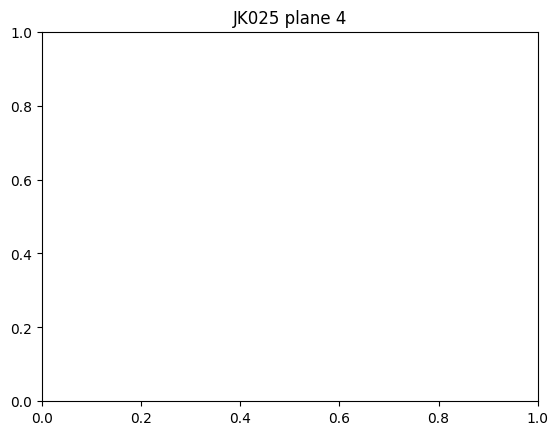

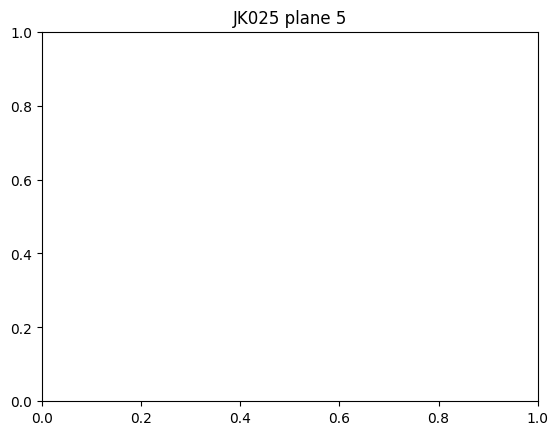

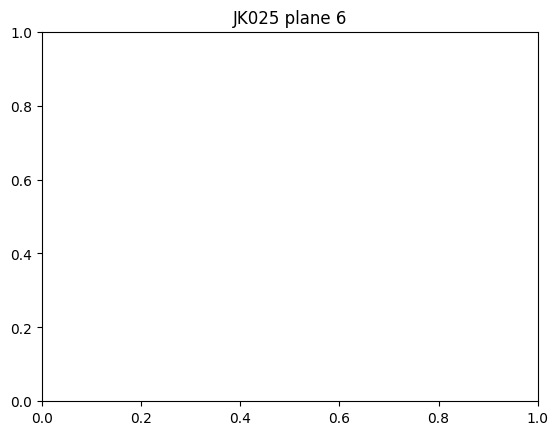

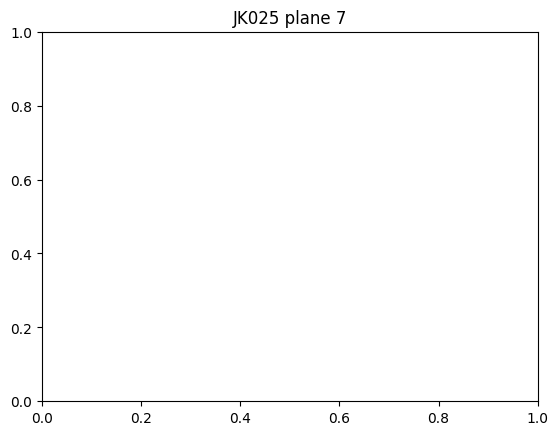

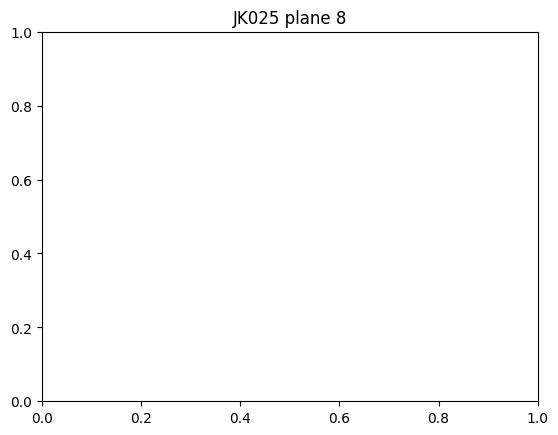

In [94]:
# model_type_list = ['cyto', 'CP']
mouse = 25
# diameter_list = range(10,25,2)
if mouse > 35:
    diameter_list = range(8,17,2)
else:
    diameter_list = range(10,25,2)
for plane in range(1,9):
    session_nums_fns = glob.glob(str(mimg_dir / f'JK{mouse:03d}_plane_{plane}_*_mimg*.tif'))
    session_nums = np.unique([fn.split(f'plane_{plane}_')[1].split('_mimg')[0] for fn in session_nums_fns])

    seg_num_df = get_seg_num_df(mouse, plane, session_nums, diameter_list)
    seg_num_df['hue'] = seg_num_df['model_type'] + ' clahe:' + seg_num_df['clahe'].astype(str)
    fig, ax = plt.subplots()
    # sns.lineplot(ax = ax, x='diameter', y='n_roi', hue='model_type', data=seg_num_df[seg_num_df['clahe']==False])
    # sns.lineplot(ax = ax, x='diameter', y='n_roi', hue='model_type', data=seg_num_df[seg_num_df['clahe']==True])
    sns.lineplot(ax = ax, x='diameter', y='n_roi', hue='hue', data=seg_num_df)
    ax.set_title(f'JK{mouse:03d} plane {plane}')

# Interim summary:
- Cyto model works better than CP
- CLAHE minimally improves, but with more faulty segmentations
    - Not needed
- Optimal diameter diverges at plane 6, for JK036 and JK039
- For the rest of the mice and planes, just run cyto without CLAHE, dimater ranging from 8 to 18
    - To get the optimal diameter in each plane
- Next, train plane-specific models with manual curation


In [105]:
# Moving non-necessary npy files to archive folder
# Lost 036 clahe CP files by mistake
import shutil
mouse = 39
for plane in range(1,9):
    moving_fns = glob.glob(str(cellpose_dir / f'JK{mouse:03d}_plane_{plane}_*_mimg_CP_*.npy'))
    for fn in moving_fns:
        shutil.move(fn, str(cellpose_dir / 'archive' / Path(fn).name))

In [118]:
import shutil
mouse = 39
for plane in range(1,9):
    moving_fns = glob.glob(str(mimg_dir / f'JK{mouse:03d}_plane_{plane}_*_mimg_clahe.tif'))
    for fn in moving_fns:
        shutil.move(fn, str(mimg_dir / 'clahe' / Path(fn).name))

In [114]:
Path(fn).stem

'JK025_plane_1_9999_2_mimg_clahe'

In [115]:
Path(fn).suffix

'.tif'

In [116]:
Path(fn).name

'JK025_plane_1_9999_2_mimg_clahe.tif'

In [111]:
# Copy specific files to "train" folder
mouse = 25
for plane in range(1,2):
    copy_fns = glob.glob(str(cellpose_dir / f'JK{mouse:03d}_plane_{plane}_*_mimg_cyto_12_seg.npy'))
    for fn in copy_fns:
        shutil.copy(fn, str(cellpose_dir / 'train' / Path(fn).name))